## Molecular Dynamics simulations of fluids

In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

In [11]:
rho    = .88 # density of Argon in natural units
dt     = 0.004 # time step size
T_0    = 1 # temperature
N_cell = 3 # number of unitcells in one direction    


N = 4 * N_cell ** 3 # the total number of particles in the system
L_box = (N / rho) ** (1 / 3) # length of the whole box
L_cell = L_box / N_cell # length of a unitcell

In [13]:
def IC_pos(N_cell, L_cell):

    pos = [[[x,  y, z], [x, 0.5 + y, 0.5 + z], [0.5 + x, y, 0.5 + z], [0.5 + x, 0.5 + y, z]] 
           for x, y, z in product(range(N_cell), range(N_cell), range(N_cell))]
    
    pos = np.array(pos).reshape((-1, 3))

    return pos * L_cell


def IC_vel(N):

    vel  = np.random.randn(N, 3)
    vel -= np.average(vel, axis=0)

    return vel 

### Computation of forces

In [24]:
pos = IC_pos(N_cell, L_cell)    # Initialize position
vel = IC_vel(N)                 # Initialize velocity

F   = np.zeros((N, N, 3))       # matrix that contains all the forces between i, j particles in 3D

ind = np.triu_indices(N, k=1)   # Indices of upper triangular matrix. Created to avoid acessing force elements via loop

In [32]:
print('position array', pos.shape)
print('velocity array', vel.shape)
print('force array', F.shape)
print('Indices of relevant portion of force array\n', 
      ind)

position array (108, 3)
velocity array (108, 3)
force array (108, 108, 3)
Indices of relevant portion of force array
 (array([  0,   0,   0, ..., 105, 105, 106]), array([  1,   2,   3, ..., 106, 107, 107]))


In [4]:
def find_force(pos, L_box, bins=30):

    # Compute all unique ij distances
    r_vec = pos[ind[0]] - pos[ind[1]]

    # Use min image criteria for distances
    r_vec = r_vec - np.rint(r_vec / L_box) * L_box

    # Compute r^2
    r_sq = np.sum(r_vec**2, axis=1)

    # Compute forces 
    dUdr = -(48 / r_sq ** 7 - 24 / r_sq ** 4)

    # Compute force maxtirx containing all forces between ij particles dU/dr * dr
    F_vec = dUdr[:, np.newaxis] * r_vec

    F[ind[0], ind[1]] = F_vec

    # Compute total force acting on each particle (i=1,...N) 
    forces = F.sum(axis=0) - F.sum(axis=1)

    # Compute potential energy, pressure and histogram of r^2 pair distances

    U = np.sum(4 / r_sq ** 6 - 4 / r_sq ** 3)

    P = np.sum(F_vec * r_vec)

    hist = np.histogram(r_sq, bins=bins, range=(0, L_box / 2))[0]
    
    return forces, U, P, hist

def time_step(pos, vel, F):

    vel += 0.5 * F * dt
    
    pos = np.mod(pos + vel * dt, L_box)

    F, pot, P, hist = find_force(pos)
    
    vel += 0.5 * F * dt
    kin = 0.5 * np.sum(vel**2)

    return pos, vel, F, pot, kin, P, hist

In [6]:
def simulate(pos, vel, L_box, freq_T=10, freq_out=50, nsteps=10000):      
    
    kins, pots, Ps, hists = [], [], [], []

    F = find_force(pos, L_box)[0]

    for t in range(10000):

        pos, vel, F, pot, kin, P, hist = time_step(pos, vel, F)

        if t % freq_T == 0:

          vel *= np.sqrt(N * 3 * T_0 / (2 * kin))
        
        if t % freq_out == 0:

            kins.append(kin)
            pots.append(pot)
            Ps.append(P)
            hists.append(hist)

    return np.array(kins), np.array(pots), np.array(Ps), np.mean(hists, axis=0)


In [10]:
kins, pots, Ps, hist = simulate()

T = np.mean(kins * 2 / (3 * N))
P = 1 - np.mean(Ps) / (3 * N * T) - 16 * np.pi * rho / (3 * T * L_box**3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, '$g(r)$')

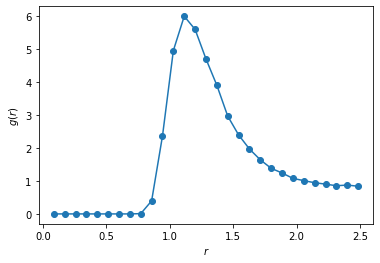

In [33]:
r = np.linspace(0, L_box / 2, bins)
pair_correlation = hist / (4 * np.pi * rho * r)


plt.plot(r, pair_correlation, '-o') 
plt.xlabel(r'$r$')  
plt.ylabel(r'$g(r)$')